In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from locale import atof, setlocale, LC_NUMERIC
import pickle
setlocale(LC_NUMERIC,'nl_nl')

'nl_nl'

In [67]:
# to list the locales available
# locale.locale_alias
# dutch version : nl_NL.ISO8859-15
# only required for identifying str to float for niche section

In [70]:
# read the mortgage tabular data from NIBUD
# note that these are percentage points
nibud_table = pd.read_excel('data/mortgage_max_burden_rates_NIBUD.xlsx', header=0, index_col=0).drop(
    labels='bruto inkomen')

In [ ]:
# shore up the nibud table column names for ease of use
cols_floors = [0.] + [atof(label[-6:-1]) for label in nibud_table.columns.to_list()][:-1]

In [82]:
to_save2 = nibud_table.copy()
to_save2.columns = cols_floors
to_save2.to_pickle('data_model_inputs/nibud_mortgage_rates_2022.pickletable')

In [56]:
# extract relevant mortgage values from baseline (may need to expand to include higher mortgage levels)
# test_sample = nibud_table.loc[:, ['2,501-3,000%', '3,001-3,500%', '3,501-4,000%', '4,001-4,500%', '4,501-5,000%']]
# test_sample.columns = [3., 3.5, 4., 4.5, 5.]
# test_sample['ori_idx'] = test_sample.index
# test_sample_melt = pd.melt(test_sample,
#                            id_vars='ori_idx')

In [78]:
# look for points where the step change in interest rate happens
points = []
to_save = {}
item_to_extract = nibud_table
for col in item_to_extract.columns:
    # also generate
    # deltas.append(item_to_extract[col][item_to_extract[col].shift() != item_to_extract[col]])
    points.append(item_to_extract[col][item_to_extract[col].shift() != item_to_extract[col]])
to_save.update(zip(cols_floors,points))

In [80]:
# save change points to pickle (uncomment as needed)
# with open('data_model_inputs/nibud_mortgage_rates_2022.pickledict', 'wb') as open_file:
#     pickle.dump(obj=to_save,
#                 file=open_file)

In [58]:
# apply interpolation function and affix name for graphing
extrapol_funcs = [(pct_set.name, interp1d(x=pct_set.index.tolist(),
                                          y=pct_set.values.tolist(),
                                          kind='previous',
                                          fill_value='extrapolate'))
                  for pct_set in to_save]
# test the extrapol functions
outputs = pd.DataFrame()
output_col_x = []
output_col_y = []
output_col_type = []
input_x = np.linspace(22000, 150000, 128)
# need to get a list of labels (variables) and a list of outputs (x and y)
for name, func in extrapol_funcs:
    output_col_type.extend([name for _ in range(len(input_x))])
    output_col_y.extend(func(input_x))
    output_col_x.extend(input_x)

outputs['x'] = output_col_x
outputs['y'] = output_col_y
outputs['type'] = output_col_type

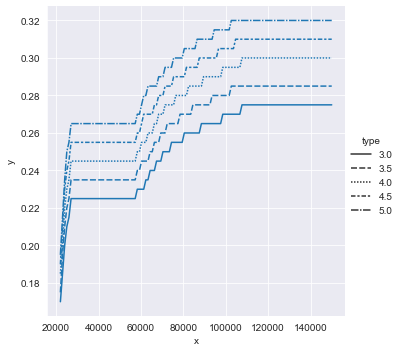

In [59]:
sns.relplot(data=outputs,
            x='x',
            y='y',
            style='type',
            kind='line')
# not very optimal graph but a better graph would be more complicated. Need to get the curve approximation for the high income part and revert to get the ladder points (though they are indeed segregated to 0.5 methods...

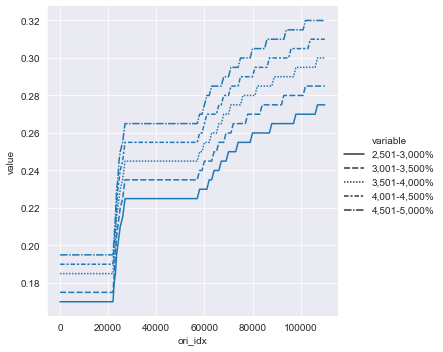

In [19]:
# sns.relplot(data=test_sample_melt,
#             x='ori_idx',
#             y='value',
#             style='variable',
#             kind='line')


## (depreciated) using wealth national data from CBS (2018)


In [2]:
# read csv file (note that they are minorly edited for ease of reading)
lti_brackets = pd.read_csv('data/Financieel_risico_hypotheekschuld__eigenwoningbezitters_ratio LTI_2018.csv',
                           sep=';', decimal=',', header=0, index_col=0, comment='#').drop(['units'], axis=1)
ltv_brackets = pd.read_csv('data/Financieel_risico_hypotheekschuld__eigenwoningbezitters_ratio LTV_2018.csv',
                           sep=';', decimal=',', header=0, index_col=0, comment='#').drop(['units'], axis=1)
# rename columns for ease of reading
lti_brackets.columns = [f'{n + 1}e' for n in range(len(lti_brackets.columns))]
ltv_brackets.columns = [f'{n + 1}e' for n in range(len(ltv_brackets.columns))]

# extract the number of households
n_households = lti_brackets.loc['Particuliere huishoudens', :]

# drop the particuliere huishoudens entry
lti_brackets = lti_brackets.drop(['Particuliere huishoudens'])
ltv_brackets = ltv_brackets.drop(['Particuliere huishoudens'])

# rename indices for ease of reading
lti_brackets.index = ['None', '0 - 3.5', '3.5 - 7', '>7']
ltv_brackets.index = ['None', '0 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1.0', '>1']

# get ratios of both datasets
lti_ratios = lti_brackets / n_households
ltv_ratios = ltv_brackets / n_households


Text(0.5, 0.98, 'Loan-to-Income ratios vs wealth deciles')

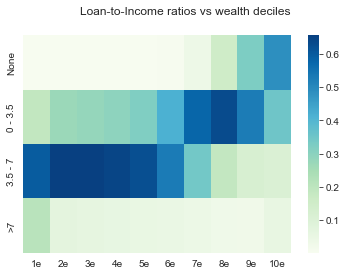

In [3]:
sns.heatmap(lti_ratios, cmap='GnBu')
plt.suptitle('Loan-to-Income ratios vs wealth deciles')

The above shows the loan-to-income ratios wrt. the wealth deciles in NL. The Y axis denotes the mortgage loan value as a multiple of the household disposable wage (besteedbare inkomen), while the X axis denotes the wealth decile (increasing = richer). It could be seen that richer households tend to have a lower ratio of LTI. This may inform on the level of savings seen in wealthier households.

For the model, the range of LTI values lying between 0 - 7 would be very useful in determining the level of mortgage repayments conducted by households, which potentially allows solving for the total mortgage servicing duration. This also informs on the importance of the inclusion of savings to reduce mortgage loans

Text(0.5, 0.98, 'Loan-to-Value ratios vs wealth deciles')

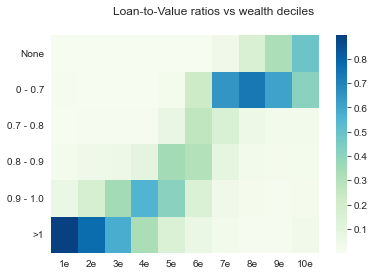

In [4]:
sns.heatmap(ltv_ratios, cmap='GnBu')
plt.suptitle('Loan-to-Value ratios vs wealth deciles')

The above shows the loan-to-value ratios wrt. wealth deciles in NL. The Y axis denotes the mortgage loan value divided by home value, while the X axis denotes the wealth decile (increasing = richer). It could be seen that richer neighbourhoods tend to have lower LTV ratios, possible corroborating the last graph that they have more savings to reduce the mortgage loan. However, the trend of lower deciles having >1 LTV might be due to the added mortgage interest, or property value going underwater.

Using house value national data (2018)

In [5]:
# read from modefied csv files
hv_averages = pd.read_csv('data/Financieel_risico_hypotheekschuld__eigenwoningbezitters_housevalue_averages.csv',
                          sep=';', decimal=',', header=0, index_col=0, comment='#').drop(['units'], axis=1)
hv_lti_brackets = pd.read_csv('data/Financieel_risico_hypotheekschuld__eigenwoningbezitters_housevalue_LTI.csv',
                              sep=';', decimal=',', header=0, index_col=0, comment='#').drop(['units'], axis=1)
hv_ltv_brackets = pd.read_csv('data/Financieel_risico_hypotheekschuld__eigenwoningbezitters_housevalue_LTV.csv',
                              sep=';', decimal=',', header=0, index_col=0, comment='#').drop(['units'], axis=1)
hv_size_quartiles = 1103.9  # gotten from original set

# rename columns
cols = [f'{n + 1}e' for n in range(1, 5)]
hv_averages.columns = cols
hv_lti_brackets.columns = cols
hv_ltv_brackets.columns = cols

# rename indices
hv_averages.index = ['n_households', 'mortgage debt', 'house value', 'base income', 'disposable income']
hv_ltv_brackets.index = ['none', '0 - 0.7', '0.7  - 0.8', '0.8 - 0.9', '0.9 - 1.0', '>1']
hv_lti_brackets.index = ['none', '0 - 3.5', '3.5 - 7', '>7']

# get ratios of both datasets
hv_lti_ratios = hv_lti_brackets / hv_size_quartiles
hv_ltv_ratios = hv_ltv_brackets / hv_size_quartiles

Text(0.5, 0.98, 'LTI ratios vs value of home')

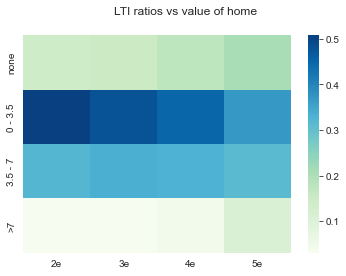

In [6]:
sns.heatmap(hv_lti_ratios, cmap='GnBu')
plt.suptitle('LTI ratios vs value of home')

<AxesSubplot:>

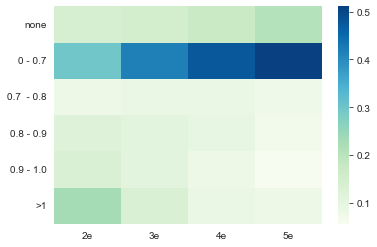

In [7]:
sns.heatmap(hv_ltv_ratios, cmap='GnBu')

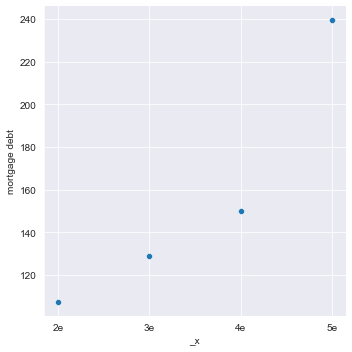

In [8]:
sns.relplot(x=cols, y=hv_averages.loc['mortgage debt', :])

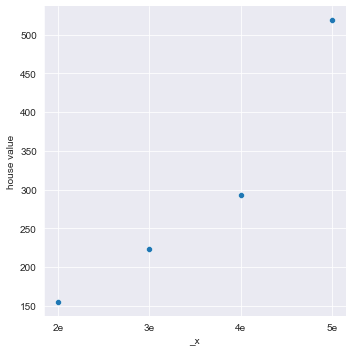

In [9]:
sns.relplot(x=cols, y=hv_averages.loc['house value'])

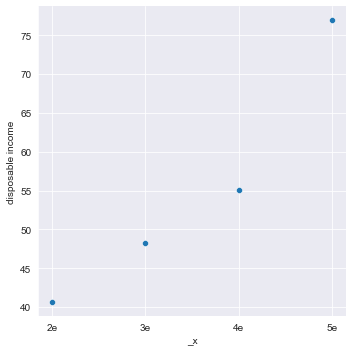

In [10]:
sns.relplot(x=cols, y=hv_averages.loc['disposable income', :])

<AxesSubplot:ylabel='Year'>

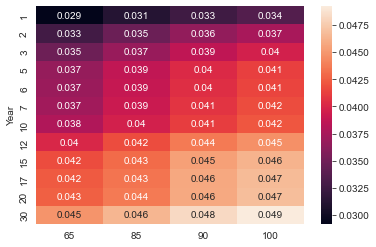

In [20]:
# read the tsv file
mortgage_interest_rates = pd.read_csv('data/mortgage_interest_rates.tsv', sep='\t',
                                      index_col=0,
                                      usecols=[0, 2, 3, 4, 5]) / 100

# mortgage_interest_rates
sns.heatmap(mortgage_interest_rates, annot=True)
# convert into numpy array?
# per agent, precalculate their loan boundaries


In [23]:
# extract the ranges
# get upper bounds
# get
mortgage_ltv_upper_bounds = [int(r) for r in mortgage_interest_rates.columns.to_list()]
mortgage_ltv_lower_bounds = [0] + mortgage_ltv_upper_bounds[:-1]
mortgage_ltv_ranges = list(zip(mortgage_ltv_lower_bounds, mortgage_ltv_upper_bounds))

